In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from kdg import kdn, kdcnn
from kdg.utils import generate_gaussian_parity, hellinger, plot_2dsim, generate_ood_samples, sample_unifrom_circle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from joblib import Parallel, delayed
from scipy.io import savemat, loadmat
from sklearn.metrics import roc_auc_score
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import activations
from tensorflow.keras import backend as bknd

### Visualize the data

<AxesSubplot: >

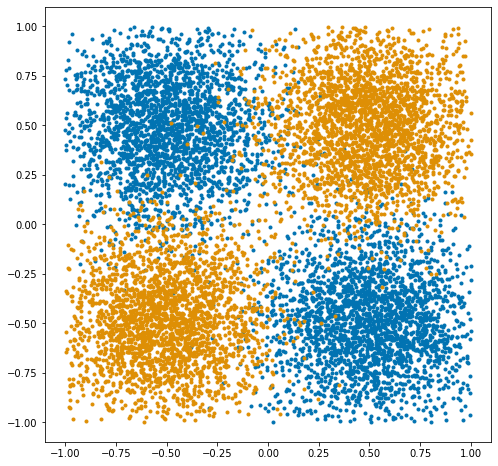

In [2]:
X, y = generate_gaussian_parity(10000)
plot_2dsim(X, y)

In [3]:
compile_kwargs = {
        "loss": "binary_crossentropy",
        "optimizer": keras.optimizers.Adam(3e-4),
    }
callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10, verbose=True)
fit_kwargs = {
        "epochs": 200,
        "batch_size": 64,
        "verbose": False,
        "callbacks": [callback],
    }

In [4]:
# network architecture [10, 10, 10, 10, 2]
def getNN(input_size, num_classes):
    network_base = keras.Sequential()
    initializer = keras.initializers.random_normal(seed=0)
    network_base.add(keras.layers.Dense(1000, kernel_initializer=initializer, input_shape=(input_size,)))
    network_base.add(keras.layers.Activation(activations.relu))
    network_base.add(keras.layers.Dense(1000, kernel_initializer=initializer))
    network_base.add(keras.layers.Activation(activations.relu))
    network_base.add(keras.layers.Dense(1000, kernel_initializer=initializer))
    network_base.add(keras.layers.Activation(activations.relu))
    network_base.add(keras.layers.Dense(1000, kernel_initializer=initializer))
    network_base.add(keras.layers.Activation(activations.relu))
    network_base.add(keras.layers.Dense(units=num_classes, activation="softmax", kernel_initializer=initializer))
    network_base.compile(**compile_kwargs)
    return network_base

In [5]:
# train Vanilla NN
nn = getNN(input_size=2, num_classes=2)
history = nn.fit(X, keras.utils.to_categorical(y), **fit_kwargs)

Metal device set to: Apple M1 Max


2023-02-24 17:10:35.540323: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-24 17:10:35.540787: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-02-24 17:10:35.701779: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-24 17:10:35.896802: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 47: early stopping


### Calculate posteriors and likelihoods using KDN

In [7]:
df = {}
model_kdn = kdn(k=.1, network=nn)
model_kdn.fit(X, y, epsilon=1e-4)

#define grids
p = np.arange(-3, 3, step=0.01)
q = np.arange(-3, 3, step=0.01)
xx, yy = np.meshgrid(p, q)

grid_samples = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1)
posterior_nn = model_kdn.network.predict(grid_samples)
posterior_kdn, likelihoods_kdn = model_kdn.predict_proba(grid_samples, return_likelihood=True)

posterior_nn = posterior_nn[:,0].reshape(600,600)
posterior_kdn = posterior_kdn[:,0].reshape(600,600)
class1_likelihoods = likelihoods_kdn[:,0].reshape(600,600)
class2_likelihoods = likelihoods_kdn[:,1].reshape(600,600)

df['posterior_dn'] = posterior_nn
df['posterior_kdn'] = posterior_kdn
df['likelihood_class1'] = class1_likelihoods
df['likelihood_class2'] = class2_likelihoods

   84/11250 [..............................] - ETA: 20s

2023-02-24 18:27:11.365542: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11250/11250 [==============================] - 20s 2ms/step


In [8]:
# get true posterior
tp_df = pd.read_csv("../true_posterior/Gaussian_xor_pdf.csv")
proba_true = 0.5*np.ones((600, 600))
tmp = np.array([tp_df["posterior"][x] for x in range(40000)])
tmp = np.flip(tmp.reshape(200, 200), axis=1)
proba_true[200:400, 200:400] = 1 - tmp
#df["true_proba"] = proba_true

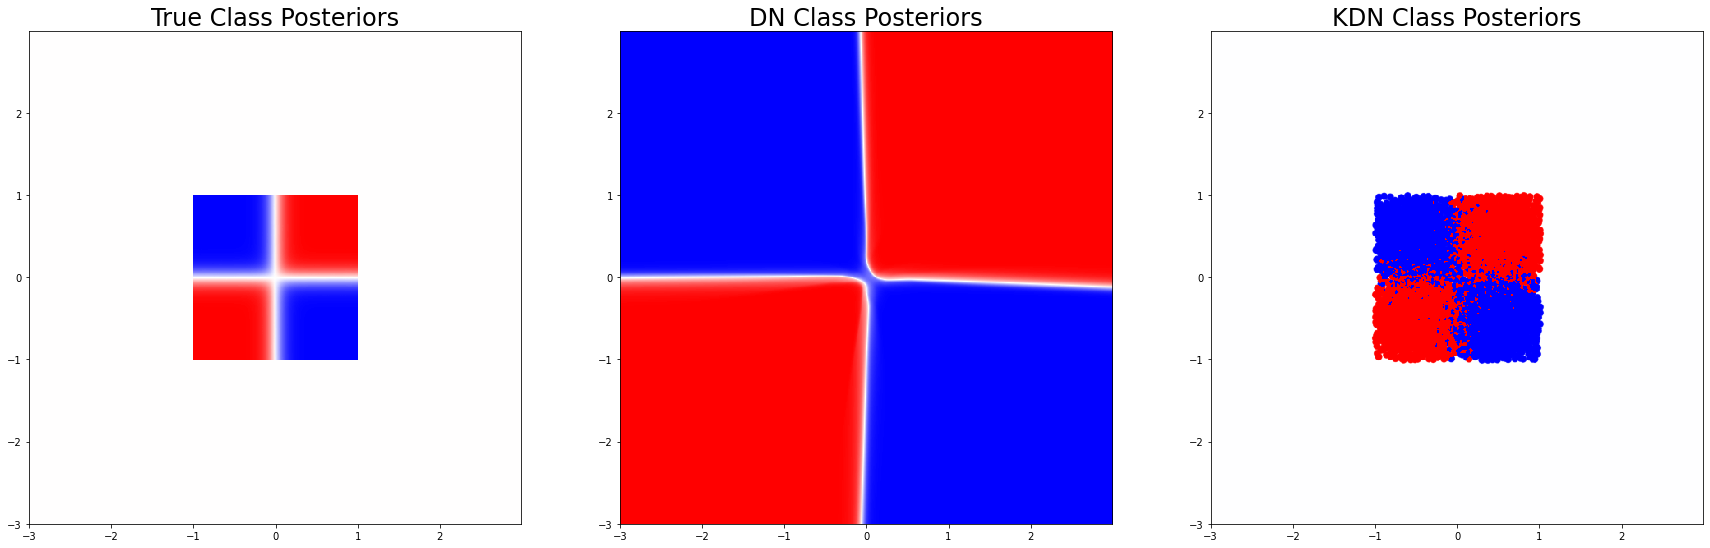

In [9]:
fig1, ax = plt.subplots(1, 3, figsize=(30, 90))

ax0 = ax[0].imshow(
    proba_true,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[0].set_title("True Class Posteriors", fontsize=24)
ax[0].set_aspect("equal")

ax1 = ax[1].imshow(
    posterior_nn,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[1].set_title("DN Class Posteriors", fontsize=24)
ax[1].set_aspect("equal")

ax2 = ax[2].imshow(
    posterior_kdn,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    interpolation="nearest",
    aspect="auto",
)
ax[2].set_title("KDN Class Posteriors", fontsize=24)
ax[2].set_aspect("equal")
plt.show()

### Visualize class likelihoods

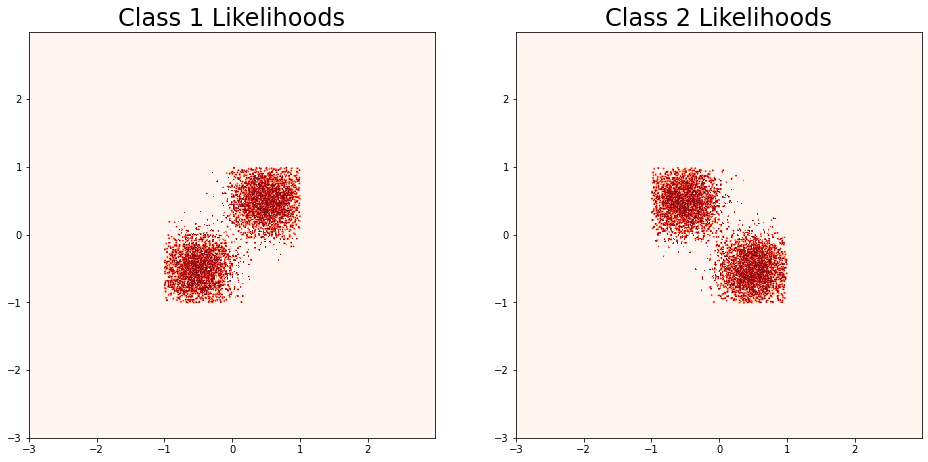

In [10]:
fig1, ax = plt.subplots(1, 2, figsize=(16, 8))

class1_likelihoods /= np.max(np.max(class1_likelihoods))
class2_likelihoods /= np.max(np.max(class2_likelihoods))

ax0 = ax[0].imshow(
    class1_likelihoods,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="Reds",
    interpolation="nearest",
    aspect="auto",
)
ax[0].set_title("Class 1 Likelihoods", fontsize=24)
ax[0].set_aspect("equal")


ax1 = ax[1].imshow(
    class2_likelihoods,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="Reds",
    interpolation="nearest",
    aspect="auto",
)
ax[1].set_title("Class 2 Likelihoods", fontsize=24)
ax[1].set_aspect("equal")

### Experiment with misclassification error and hellinger distance

In [11]:
likelihoods_kdn

array([[2.33696873e-05, 2.35098835e-05],
       [2.33696873e-05, 2.35098835e-05],
       [2.33696873e-05, 2.35098835e-05],
       ...,
       [2.33696873e-05, 2.35098835e-05],
       [2.33696873e-05, 2.35098835e-05],
       [2.33696873e-05, 2.35098835e-05]])

In [10]:
mc_reps = 10
sample_size = [50, 100, 500, 1000, 5000, 10000]
n_test = 1000

tp_df = pd.read_csv("../true_posterior/Gaussian_xor_pdf.csv")
true_posterior = tp_df['posterior']
true_posterior = np.vstack((1-true_posterior.ravel(), true_posterior.ravel())).T
        
    
def experiment_in(sample, n_test, true_posterior):
    X, y = generate_gaussian_parity(sample)
    X_test, y_test = generate_gaussian_parity(n_test)
    
    nn = getNN(input_size=2, num_classes=2)
    history = nn.fit(X, keras.utils.to_categorical(y), **fit_kwargs)
    model_kdn = kdn(k=.1, network=nn)
    model_kdn.fit(X, y)
    
    p = np.arange(-1, 1, step=0.01)
    q = np.arange(-1, 1, step=0.01)
    xx, yy = np.meshgrid(p, q)

    grid_samples = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1)

    error_kdn = 1 - np.mean(model_kdn.predict(X_test)==y_test)   
    error_dn = 1 - np.mean(np.argmax(
        model_kdn.network.predict(X_test), axis=1
    )==y_test)
    proba_kdn = model_kdn.predict_proba(grid_samples)
    proba_dn = model_kdn.network.predict(grid_samples)
    hellinger_dis_kdn = hellinger(1-true_posterior, proba_kdn)
    hellinger_dis_dn = hellinger(1-true_posterior, proba_dn)
    mmcIn_dn = np.mean(np.max(proba_dn, axis=1)) 
    mmcIn_kdn = np.mean(np.max(proba_kdn, axis=1))
    
    return error_kdn, error_dn, hellinger_dis_kdn, hellinger_dis_dn, mmcIn_kdn, mmcIn_dn

def experiment_out(in_sample, r, n_test):
    X, y = generate_gaussian_parity(in_sample)
    nn = getNN(input_size=2, num_classes=2)
    history = nn.fit(X, keras.utils.to_categorical(y), **fit_kwargs)
    
    model_kdn = kdn(k=.1, network=nn)
    model_kdn.fit(X, y)

    X_ood = sample_unifrom_circle(n=n_test, r=r)
    mmcOut_dn = np.mean(np.max(
        model_kdn.network.predict(X_ood), axis=1
        )
    )
    mmcOut_kdn = np.mean(np.max(model_kdn.predict_proba(X_ood), axis=1))
    
    return mmcOut_kdn, mmcOut_dn
        
    
error_kdn_med = []
error_kdn_25 = []
error_kdn_75 = []
error_dn_med = []
error_dn_25 = []
error_dn_75 = []

hellinger_kdn_med = []
hellinger_kdn_25 = []
hellinger_kdn_75 = []
hellinger_dn_med = []
hellinger_dn_25 = []
hellinger_dn_75 = []

mmcIn_kdn_med = []
mmcIn_kdn_25 = []
mmcIn_kdn_75 = []
mmcIn_dn_med = []
mmcIn_dn_25 = []
mmcIn_dn_75 = []

mmcOut_kdn_med = []
mmcOut_kdn_25 = []
mmcOut_kdn_75 = []
mmcOut_dn_med = []
mmcOut_dn_25 = []
mmcOut_dn_75 = []

#### do out-of-distribution results ####
for r in np.arange(0,10.5,.5):
    mmcOut_kdn = []
    mmcOut_dn = []
    res = Parallel(n_jobs=-1)(
            delayed(experiment_out)(
                    1000,
                    r,
                    n_test
                    ) for _ in range(mc_reps)
                )
    
    for ii in range(mc_reps):
        mmcOut_kdn.append(res[ii][0])
        mmcOut_dn.append(res[ii][1])
    
    
    mmcOut_kdn_med.append(
        np.median(mmcOut_kdn)
    )
    mmcOut_kdn_25.append(
        np.quantile(mmcOut_kdn, [0.25])[0]
    )
    mmcOut_kdn_75.append(
        np.quantile(mmcOut_kdn, [0.75])[0]
    )
    
    mmcOut_dn_med.append(
        np.median(mmcOut_dn)
    )
    mmcOut_dn_25.append(
        np.quantile(mmcOut_dn, [0.25])[0]
    )
    mmcOut_dn_75.append(
        np.quantile(mmcOut_dn, [0.75])[0]
    )
    
    
#### do in-distribution results ####
for sample in sample_size:
    res = Parallel(n_jobs=-1)(
            delayed(experiment_in)(
                    sample,
                    n_test,
                    true_posterior
                    ) for _ in range(mc_reps)
                )

    
    err_kdn = []
    err_dn = []
    hellinger_kdn = []
    hellinger_dn = []
    mmcIn_kdn = []
    mmcIn_dn = []
    for ii in range(mc_reps):
        err_kdn.append(res[ii][0])
        err_dn.append(res[ii][1])
        hellinger_kdn.append(res[ii][2])
        hellinger_dn.append(res[ii][3])
        mmcIn_kdn.append(res[ii][4])
        mmcIn_dn.append(res[ii][5])

    error_kdn_med.append(
        np.median(err_kdn)
    )
    error_kdn_25.append(
        np.quantile(err_kdn, [0.25])[0]
    )
    error_kdn_75.append(
        np.quantile(err_kdn, [0.75])[0]
    )

    error_dn_med.append(
        np.median(err_dn)
    )
    error_dn_25.append(
        np.quantile(err_dn, [0.25])[0]
    )
    error_dn_75.append(
        np.quantile(err_dn, [0.75])[0]
    )
    
    hellinger_kdn_med.append(
        np.median(hellinger_kdn)
    )
    hellinger_kdn_25.append(
        np.quantile(hellinger_kdn, [0.25])[0]
    )
    hellinger_kdn_75.append(
        np.quantile(hellinger_kdn, [0.75])[0]
    )

    hellinger_dn_med.append(
        np.median(hellinger_dn)
    )
    hellinger_dn_25.append(
        np.quantile(hellinger_dn, [0.25])[0]
    )
    hellinger_dn_75.append(
        np.quantile(hellinger_dn, [0.75])[0]
    )

    mmcIn_kdn_med.append(
        np.median(mmcIn_kdn)
    )
    mmcIn_kdn_25.append(
        np.quantile(mmcIn_kdn, [0.25])[0]
    )
    mmcIn_kdn_75.append(
        np.quantile(mmcIn_kdn, [0.75])[0]
    )

    mmcIn_dn_med.append(
        np.median(mmcIn_dn)
    )
    mmcIn_dn_25.append(
        np.quantile(mmcIn_dn, [0.25])[0]
    )
    mmcIn_dn_75.append(
        np.quantile(mmcIn_dn, [0.75])[0]
    )


df['error_kdn_med'] = error_kdn_med
df['error_kdn_25'] = error_kdn_25
df['error_kdn_75'] = error_kdn_75

df['error_dn_med'] = error_dn_med
df['error_dn_25'] = error_dn_25
df['error_dn_75'] = error_dn_75

df['hellinger_kdn_med'] = hellinger_kdn_med
df['hellinger_kdn_25'] = hellinger_kdn_25
df['hellinger_kdn_75'] = hellinger_kdn_75

df['hellinger_dn_med'] = hellinger_dn_med
df['hellinger_dn_25'] = hellinger_dn_25
df['hellinger_dn_75'] = hellinger_dn_75

df['mmcIn_kdn_med'] = mmcIn_kdn_med
df['mmcIn_kdn_25'] = mmcIn_kdn_25
df['mmcIn_kdn_75'] = mmcIn_kdn_75

df['mmcIn_dn_med'] = mmcIn_dn_med
df['mmcIn_dn_25'] = mmcIn_dn_25
df['mmcIn_dn_75'] = mmcIn_dn_75

df['mmcOut_kdn_med'] = mmcOut_kdn_med
df['mmcOut_kdn_25'] = mmcOut_kdn_25
df['mmcOut_kdn_75'] = mmcOut_kdn_75

df['mmcOut_dn_med'] = mmcOut_dn_med
df['mmcOut_dn_25'] = mmcOut_dn_25
df['mmcOut_dn_75'] = mmcOut_dn_75

INFO:tensorflow:Assets written to: ram://66446de1-70ae-4290-9e6c-9f9c7f196cbc/assets
INFO:tensorflow:Assets written to: ram://c70d8be4-f52b-4214-91b8-070c849f7aec/assets
INFO:tensorflow:Assets written to: ram://f9b60649-2483-4277-b355-bb882632e371/assets
INFO:tensorflow:Assets written to: ram://f0531362-fa8e-46ab-91bc-9b60f59e7c03/assets
INFO:tensorflow:Assets written to: ram://fd9734aa-7810-4ade-a9a8-72f3e8255373/assets
INFO:tensorflow:Assets written to: ram://f51c6c5b-8c09-41a6-9555-dfdc97ebbf8d/assets


2023-02-20 21:08:04.458012: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-20 21:08:04.458143: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Max
INFO:tensorflow:Assets written to: ram://75d3e322-dff5-42a0-9177-22b8b7624477/assets
Metal device set to: Apple M1 Max


2023-02-20 21:08:04.811025: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-20 21:08:04.811154: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-02-20 21:08:04.913232: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-20 21:08:05.117335: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 21:08:05.312294: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Metal device set to: Apple M1 Max
INFO:tensorflow:Assets written to: ram://f1d0f7f9-344d-4d68-b15c-f6edddf8f20f/assets


2023-02-20 21:08:05.347698: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-20 21:08:05.347814: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-02-20 21:08:05.584064: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Metal device set to: Apple M1 Max
INFO:tensorflow:Assets written to: ram://fc9f87d3-19ce-4c24-8473-eda3260344ef/assets


2023-02-20 21:08:06.007736: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-20 21:08:06.034990: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-20 21:08:06.035121: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-02-20 21:08:06.282014: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 21:08:06.623759: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been bu

Metal device set to: Apple M1 Max
INFO:tensorflow:Assets written to: ram://57ddbeb1-bb60-4c49-b739-4bc3bdcb8595/assets


2023-02-20 21:08:06.968661: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Metal device set to: Apple M1 Max


2023-02-20 21:08:07.335524: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-20 21:08:07.335670: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-02-20 21:08:07.356019: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-20 21:08:07.616427: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 21:08:07.965382: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-20 21:08:08.050398: I tensorflow/core/common_runtime/pluggable_device/pluggable_de

Metal device set to: Apple M1 Max


2023-02-20 21:08:08.243322: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 21:08:08.734414: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-20 21:08:09.168843: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Metal device set to: Apple M1 Max


2023-02-20 21:08:09.413090: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-20 21:08:09.413217: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-02-20 21:08:10.724486: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-20 21:08:10.795995: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-20 21:08:10.796139: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow de

Metal device set to: Apple M1 Max


2023-02-20 21:08:11.247161: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 21:08:12.404005: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-20 21:08:12.490401: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-20 21:08:12.490576: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Max


2023-02-20 21:08:12.956071: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 35: early stopping


2023-02-20 21:08:13.963006: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-20 21:08:14.891604: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 53: early stopping
Epoch 54: early stopping
Epoch 42: early stopping
Epoch 66: early stopping
Epoch 74: early stopping
Epoch 45: early stopping
Epoch 49: early stopping


2023-02-20 21:08:26.946855: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 6ms/step


2023-02-20 21:08:27.776039: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step
Epoch 97: early stopping


2023-02-20 21:08:29.055160: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step


2023-02-20 21:08:29.547759: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 21:08:29.618922: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 21:08:29.723814: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step
Epoch 100: early stopping


2023-02-20 21:08:31.005927: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-02-20 21:08:32.928053: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 21:08:35.030234: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 21:08:36.473178: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
INFO:tensorflow:Assets written to: ram://dabb17d3-ba86-4909-9556-e3ef45b5f099/assets
INFO:tensorflow:Assets written to: ram://83ed9a78-437b-4abd-9c9a-c9660ff5807b/assets


2023-02-20 21:08:37.616822: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://193e3585-105c-477c-8840-86a4d6cff077/assets


2023-02-20 21:08:38.153262: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://820e996f-eac6-4a51-ba0a-edc15c4202f7/assets


2023-02-20 21:08:38.833180: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://8deabaa5-6046-4fa0-9130-38e5923693e8/assets


2023-02-20 21:08:39.422858: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://63a9d6fc-ccf4-4aad-b604-a55fbb51b047/assets


2023-02-20 21:08:40.038785: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://cccdb583-2c9d-492a-822b-10217af16785/assets


2023-02-20 21:08:40.663644: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://62c198cc-07c7-483b-a61d-5ffc580079c0/assets


2023-02-20 21:08:41.477943: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 21:08:42.666404: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://3dd38213-8006-454a-a08f-1dd2ca416e85/assets


2023-02-20 21:08:45.000578: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://f8b8e236-0f71-4f0d-a061-b32f60cf5183/assets
Epoch 38: early stopping


2023-02-20 21:08:47.470244: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 67: early stopping
Epoch 68: early stopping
Epoch 84: early stopping
Epoch 76: early stopping
Epoch 93: early stopping


2023-02-20 21:08:57.886611: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step
Epoch 80: early stopping


2023-02-20 21:09:00.258722: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step


2023-02-20 21:09:01.054429: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-02-20 21:09:03.691387: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-02-20 21:09:04.291850: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 21:09:04.399284: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step
Epoch 115: early stopping
Epoch 89: early stopping
Epoch 106: early stopping


2023-02-20 21:09:08.566197: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 21:09:11.027362: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 21:09:11.067826: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 21:09:11.333117: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://4db2c09a-ddf7-44ca-b212-4b598523ae8c/assets
INFO:tensorflow:Assets written to: ram://37ed61ea-3142-423b-971e-baa499bf7918/assets


2023-02-20 21:09:12.442311: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://4cf97522-5c4a-4130-81b1-875604cf22e9/assets


2023-02-20 21:09:12.981490: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://a2228bf8-6361-4e0f-bb9c-8c3e1630b43a/assets


2023-02-20 21:09:13.508289: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://fce2a0d8-db97-40c0-aac3-b7ab2d8729bb/assets


2023-02-20 21:09:14.195849: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://439bfa1b-2bb2-4725-9320-91be607f3a0a/assets


2023-02-20 21:09:14.858958: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://cc8e1be2-1289-4c29-b398-da2a52c3ea09/assets


2023-02-20 21:09:15.552399: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 21:09:16.282286: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://10a0c145-548d-4ea2-8868-63708ce189f6/assets


2023-02-20 21:09:17.459727: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://5aea35e0-a10c-452a-ba32-8e49b105bf73/assets


2023-02-20 21:09:18.959193: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://f883cee9-f308-4c59-90dc-6aa52477ea61/assets


2023-02-20 21:09:21.752391: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 58: early stopping
Epoch 58: early stopping
Epoch 42: early stopping
Epoch 64: early stopping
Epoch 71: early stopping
Epoch 48: early stopping


2023-02-20 21:09:30.714151: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step
Epoch 80: early stopping


2023-02-20 21:09:35.011923: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-02-20 21:09:35.323907: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 6ms/step


2023-02-20 21:09:37.402425: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 21:09:37.542689: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 21:09:37.712825: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 92: early stopping
Epoch 130: early stopping


2023-02-20 21:09:39.899487: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Epoch 106: early stopping


2023-02-20 21:09:44.480841: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 21:09:45.833532: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 21:09:47.322340: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://6bad6a12-5273-441e-9df3-bf1088b9d0d9/assets
INFO:tensorflow:Assets written to: ram://e74bfe47-6eff-4e1e-8492-61fe711af6da/assets


2023-02-20 21:09:48.451127: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://1da27842-d5ac-4cb1-b9a7-68e9abaa2b88/assets


2023-02-20 21:09:49.000033: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://86aeb1d1-4a49-43ce-ab1a-c896310c736e/assets


2023-02-20 21:09:49.570141: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://b2356a80-f898-4011-a2ee-c2b69be2da1d/assets


2023-02-20 21:09:50.330146: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://58f0d650-8698-430e-98de-006d898a6dd9/assets


2023-02-20 21:09:50.856786: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://98a7a67e-e0c8-42f3-9716-a0c16e97bc57/assets


2023-02-20 21:09:51.500692: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 21:09:52.252721: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://a7164211-f7bb-4746-868d-b453263f06f7/assets


2023-02-20 21:09:53.320106: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://cac5df8d-1c6e-4bcb-9a19-8d14b963ab9d/assets


2023-02-20 21:09:54.713232: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 35: early stopping
INFO:tensorflow:Assets written to: ram://fc0bd50d-efa7-4c30-a67c-78d707128a21/assets


2023-02-20 21:09:59.272328: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 33: early stopping


2023-02-20 21:10:02.981533: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 6ms/step
Epoch 65: early stopping
Epoch 94: early stopping
Epoch 84: early stopping
Epoch 103: early stopping


2023-02-20 21:10:12.679927: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 21:10:12.770044: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step
Epoch 94: early stopping


2023-02-20 21:10:13.308105: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step
Epoch 141: early stopping


2023-02-20 21:10:17.635127: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step


2023-02-20 21:10:19.720113: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-02-20 21:10:20.640601: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 21:10:23.312362: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Epoch 139: early stopping
Epoch 186: early stopping


2023-02-20 21:10:30.390483: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 21:10:30.567293: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://b1eaa561-4b44-4a3d-a91f-1cf50bbb5f0e/assets
INFO:tensorflow:Assets written to: ram://9475ddfb-e948-4000-899f-767d94d0ab36/assets


2023-02-20 21:10:31.675497: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://4153f18f-f266-4b57-9bb4-8f8b3217c096/assets


2023-02-20 21:10:32.215021: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://b5994f91-2111-425c-97a9-02843d713a3b/assets


2023-02-20 21:10:32.763401: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://34639703-20e3-4f73-a438-6858fd5a34b1/assets


2023-02-20 21:10:33.361774: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://e94a4c1a-ec5a-45d1-a857-fcd97e348583/assets


2023-02-20 21:10:34.072565: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://b44f6790-53a4-47ed-bbc5-952aeff8dcb2/assets


2023-02-20 21:10:34.679188: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://86e7b73f-df91-48f8-923d-a15727870f76/assets


2023-02-20 21:10:35.477122: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 21:10:36.424246: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 28: early stopping
INFO:tensorflow:Assets written to: ram://b46f137c-e858-4e8f-ad74-38fe1513b826/assets


2023-02-20 21:10:37.472438: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://48fd4727-cf5d-4c1f-b0cd-56c4fd7cff5a/assets


2023-02-20 21:10:39.055985: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 48: early stopping
Epoch 27: early stopping
Epoch 49: early stopping


2023-02-20 21:10:44.818944: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step
Epoch 42: early stopping


2023-02-20 21:10:48.258647: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 21:10:48.380397: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 6ms/step
Epoch 77: early stopping


2023-02-20 21:10:49.768642: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step
Epoch 61: early stopping
Epoch 77: early stopping


2023-02-20 21:10:53.775575: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Epoch 88: early stopping


2023-02-20 21:10:55.999300: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 21:10:57.259399: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step
Epoch 142: early stopping


2023-02-20 21:10:58.215228: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 21:11:00.660242: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 21:11:03.673063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://cefb86ff-61f6-41f5-8b7e-176578f1d571/assets
INFO:tensorflow:Assets written to: ram://49d9b295-be89-4ee3-b562-8ff040e27dfc/assets


2023-02-20 21:11:04.824963: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://b0c41403-e8a7-455b-b1d3-472cb805a40e/assets


2023-02-20 21:11:05.367644: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://662891a8-97ab-4f72-b981-925544e9b2c5/assets


2023-02-20 21:11:05.999947: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://ac8a589a-994e-4f39-beb0-aff1039b50f8/assets


2023-02-20 21:11:06.585165: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://a884c442-b6e1-4fc0-9664-2593f7e5ddff/assets


2023-02-20 21:11:07.291987: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://3a09c40c-3463-43fe-8505-0e3da849719b/assets


2023-02-20 21:11:07.959014: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://eefc6331-2a44-472d-9da2-93fa957f8395/assets


2023-02-20 21:11:08.589932: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 21:11:09.356689: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://2a17a656-9b38-4538-a48b-ca13786fb588/assets
Epoch 33: early stopping


2023-02-20 21:11:11.058754: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://6c6e37e6-19a9-43df-a847-d7ff2301aea3/assets


2023-02-20 21:11:12.730938: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 30: early stopping
Epoch 78: early stopping
Epoch 47: early stopping
Epoch 60: early stopping
Epoch 58: early stopping


2023-02-20 21:11:25.055958: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 6ms/step
Epoch 71: early stopping


2023-02-20 21:11:28.979572: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 6ms/step


2023-02-20 21:11:29.756105: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step


2023-02-20 21:11:30.521395: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step


2023-02-20 21:11:31.102669: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-02-20 21:11:31.663268: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Epoch 129: early stopping
Epoch 108: early stopping
Epoch 136: early stopping


2023-02-20 21:11:35.057022: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 21:11:38.945007: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 21:11:39.334977: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 21:11:39.501017: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://b843b2bf-fa39-4a99-bfa8-9879439a17de/assets
INFO:tensorflow:Assets written to: ram://2827aa7a-feb1-40c8-8b53-d8723f195715/assets


2023-02-20 21:11:40.739607: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://617b9b7f-3822-4b39-9bf3-2d841ace3a19/assets


2023-02-20 21:11:41.275206: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://4c88cc9c-70e8-42b2-8a73-78184e79821f/assets


2023-02-20 21:11:41.823923: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://202c4af4-8746-4d87-b03a-b9413f3f0c99/assets


2023-02-20 21:11:42.411610: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://3bfaf414-093e-48d8-a7c8-7b0070e7dd1a/assets


2023-02-20 21:11:43.014427: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://5df169b9-0187-4bd2-b33d-cf01dcd0cdad/assets


2023-02-20 21:11:43.796028: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 21:11:44.569418: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://bae950aa-3a8f-4ddf-9816-96f08961509b/assets


2023-02-20 21:11:45.586804: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://6df76dd9-3054-418b-a510-c75480dc1abc/assets
INFO:tensorflow:Assets written to: ram://cdbf58cd-679b-494c-84d3-414eb3f81300/assets


2023-02-20 21:11:48.078028: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 21:11:49.014002: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 43: early stopping
Epoch 66: early stopping
Epoch 60: early stopping


2023-02-20 21:12:01.215511: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step
Epoch 100: early stopping
Epoch 52: early stopping
Epoch 75: early stopping
Epoch 72: early stopping
Epoch 93: early stopping


2023-02-20 21:12:04.619565: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step


2023-02-20 21:12:05.725107: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step
Epoch 66: early stopping
Epoch 105: early stopping


2023-02-20 21:12:09.818823: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 21:12:09.904015: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-02-20 21:12:10.167500: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 21:12:11.145530: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 21:12:11.722918: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 21:12:12.906857: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 21:12:15.535467: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://914a82c5-6bb9-42d3-a9b2-18d117ca8088/assets
INFO:tensorflow:Assets written to: ram://1dbea910-2960-4029-9882-60515ad0931c/assets


2023-02-20 21:12:16.641598: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://0b29a522-3fd0-4b71-88cd-56c2fed83b8c/assets


2023-02-20 21:12:17.262229: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://fad6bb3a-b53e-403b-8272-c1fd9116aa85/assets


2023-02-20 21:12:17.820718: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://262f522c-da4c-4c84-859a-1fdbaa8c911a/assets


2023-02-20 21:12:18.391477: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://2c136045-c86e-4f52-958b-15930b3586ee/assets


2023-02-20 21:12:19.009878: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://fec64f2c-4974-4b32-b443-a8803a9999ef/assets


2023-02-20 21:12:19.752718: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://07844c9a-ae4b-43d6-acf9-d49116548416/assets


2023-02-20 21:12:20.395364: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 21:12:21.310550: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://ad860058-4192-4713-ada6-955f8df34781/assets


2023-02-20 21:12:22.580504: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://642ebd85-39d5-49ba-a652-4cb8853aa676/assets


2023-02-20 21:12:26.799020: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 50: early stopping
Epoch 53: early stopping
Epoch 83: early stopping
Epoch 52: early stopping
Epoch 56: early stopping
Epoch 64: early stopping
Epoch 64: early stopping


2023-02-20 21:12:37.525249: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 9ms/step


2023-02-20 21:12:39.289884: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 6ms/step


2023-02-20 21:12:41.749184: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 21:12:41.863988: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/32 [==================>...........] - ETA: 0s

2023-02-20 21:12:42.035421: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-02-20 21:12:42.250534: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 21:12:42.420533: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Epoch 116: early stopping
Epoch 100: early stopping
Epoch 151: early stopping


2023-02-20 21:12:52.746346: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 21:12:53.791928: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-02-20 21:12:54.314897: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://f370bb7e-ae34-470c-8eee-9a78d20e3b2b/assets
INFO:tensorflow:Assets written to: ram://c2c8d457-3077-48cd-9fc9-474701dbe762/assets


2023-02-20 21:12:55.451665: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://e1067958-e02c-4a90-ba07-f9ec76911f3a/assets


2023-02-20 21:12:56.067551: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://95c9d9dd-3b52-4799-b6fc-8755243bae8c/assets


2023-02-20 21:12:56.622812: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://5ecf7ed1-0954-4767-9d1b-8ba8b510bc7b/assets


2023-02-20 21:12:57.194205: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://701a07fe-d423-4efd-a0bf-bb6d4551841e/assets


2023-02-20 21:12:57.824992: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 21:12:58.459820: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://2691dcbb-a78a-4d6b-b129-26d36c530ebb/assets


2023-02-20 21:12:59.318536: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://f8c5c0e8-7799-4251-b34c-4060c24fc679/assets


2023-02-20 21:13:00.301039: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://585ec201-5d23-4179-8d71-dfe1a99d1574/assets


2023-02-20 21:13:01.582698: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://6ddc933e-99b3-45bc-aa3f-8966f636a814/assets


2023-02-20 21:13:03.940113: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 49: early stopping
Epoch 20: early stopping
Epoch 43: early stopping
Epoch 55: early stopping
Epoch 65: early stopping
Epoch 64: early stopping


2023-02-20 21:13:13.675165: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step


2023-02-20 21:13:14.649043: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 6ms/step
Epoch 60: early stopping


2023-02-20 21:13:16.806908: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 6ms/step


2023-02-20 21:13:17.810239: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step
Epoch 73: early stopping


2023-02-20 21:13:20.447658: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 21:13:20.632166: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step
Epoch 121: early stopping
Epoch 126: early stopping


2023-02-20 21:13:23.182908: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 21:13:26.150974: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 21:13:28.754555: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 21:13:28.966000: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://d3242745-7b8a-4c29-8842-43dd4c5d3247/assets
INFO:tensorflow:Assets written to: ram://e9ac17b1-0245-4ae6-9643-834b7d24bef8/assets


2023-02-20 21:13:30.129414: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://1e3c7562-0f9c-4449-9bc7-f39ad29ca719/assets


2023-02-20 21:13:30.781872: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://9e9fe9a8-2921-468e-8f3b-5d7fcfa3ac7b/assets


2023-02-20 21:13:31.357573: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://33b581d3-a7f7-4324-9342-9923c182bf2c/assets


2023-02-20 21:13:31.907241: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://46e77b4d-cb4e-437c-a9ae-a33e9447ecc8/assets


2023-02-20 21:13:32.505491: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://0a1d9da8-a0ed-424f-87f4-2f04b0f253f5/assets


2023-02-20 21:13:33.174849: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 21:13:33.914402: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://e149f243-511d-4482-a207-0066de062f0e/assets


2023-02-20 21:13:35.490498: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://f34da716-40fa-4ade-9313-6f8f6ad6dccf/assets


2023-02-20 21:13:37.309210: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://41727ca3-1e8c-4f37-8d2b-8a0726868695/assets


2023-02-20 21:13:39.144350: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 41: early stopping
Epoch 49: early stopping
Epoch 80: early stopping
Epoch 76: early stopping
Epoch 44: early stopping


2023-02-20 21:13:51.106166: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 6ms/step
Epoch 57: early stopping


2023-02-20 21:13:53.705744: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step


2023-02-20 21:13:54.374815: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step
Epoch 116: early stopping


2023-02-20 21:13:55.151495: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step
Epoch 111: early stopping
 1/32 [..............................] - ETA: 1s

2023-02-20 21:13:56.188067: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-02-20 21:14:00.428065: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step
Epoch 140: early stopping
Epoch 107: early stopping


2023-02-20 21:14:02.044499: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 21:14:02.883572: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 21:14:06.948511: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 21:14:07.080891: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
INFO:tensorflow:Assets written to: ram://0c7eb406-abab-4e89-a396-fd7cb66d5588/assets
INFO:tensorflow:Assets written to: ram://db05a4e2-bce8-4bf4-97db-55eff8e0819b/assets


2023-02-20 21:14:08.193319: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://71268def-6c2e-4c16-bffd-879c0a389c1b/assets


2023-02-20 21:14:08.741043: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://cddcb9e6-962c-4fe6-bcc2-dc382ab6c04f/assets


2023-02-20 21:14:09.379996: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://811ff138-52f8-422c-969d-2d37b8b37aaf/assets


2023-02-20 21:14:09.943442: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://a1c44429-07e5-44c5-99cc-7bfa079d8e31/assets


2023-02-20 21:14:10.532169: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://9d395989-6b69-43b0-983c-9af94d594f04/assets


2023-02-20 21:14:11.148163: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 21:14:11.825814: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 26: early stopping
INFO:tensorflow:Assets written to: ram://167e94ec-24f2-48bb-932d-8791d1739bd3/assets
INFO:tensorflow:Assets written to: ram://694a40cd-81d7-49ae-91cb-fd2115779edf/assets


2023-02-20 21:14:12.887989: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 21:14:13.815391: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://d4d0c8b5-4520-47a5-aff4-c1548d2e29b8/assets
Epoch 25: early stopping


2023-02-20 21:14:16.653887: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 42: early stopping


2023-02-20 21:14:20.635010: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 6ms/step
Epoch 32: early stopping
Epoch 71: early stopping
Epoch 47: early stopping


2023-02-20 21:14:25.991527: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step
Epoch 84: early stopping
17/32 [==============>...............] - ETA: 0s

2023-02-20 21:14:29.251398: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step
Epoch 110: early stopping
17/32 [==============>...............] - ETA: 0s

2023-02-20 21:14:30.534318: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-02-20 21:14:32.118803: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 21:14:32.303702: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step
Epoch 125: early stopping


2023-02-20 21:14:37.161964: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-02-20 21:14:38.935874: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 21:14:40.538051: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Epoch 144: early stopping


2023-02-20 21:14:46.616235: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://365b5e36-cd29-4a2b-80de-6522107f5dc5/assets
INFO:tensorflow:Assets written to: ram://51d03686-e29e-4fa4-92c3-5b69b334d494/assets


2023-02-20 21:14:47.712519: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://e0c388fe-aeeb-43d9-aecb-c060f8f751f6/assets


2023-02-20 21:14:48.242100: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://7bea9003-2232-4d29-937d-9b01bf28e0f4/assets


2023-02-20 21:14:48.899770: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://0b3b452f-8adb-453f-871e-6bb5803a3e9f/assets


2023-02-20 21:14:49.466442: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://3fbc7199-19e8-4597-b416-6dc18375248d/assets


2023-02-20 21:14:50.018054: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://79f1defc-32aa-41cb-98db-c65a2f74754e/assets


2023-02-20 21:14:50.656719: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://bbb45eb7-0075-4d6d-8b05-2cd4ca6090aa/assets


2023-02-20 21:14:51.357080: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 27: early stopping


2023-02-20 21:14:52.161432: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://d82b6f58-a223-4671-8703-bd66ea2ab218/assets


2023-02-20 21:14:53.613411: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://abaab985-deac-4b4c-99e6-2a254e95b508/assets


2023-02-20 21:14:55.097352: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 21:14:59.315444: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 6ms/step
Epoch 44: early stopping
Epoch 60: early stopping
Epoch 72: early stopping
Epoch 59: early stopping


2023-02-20 21:15:08.616541: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step


2023-02-20 21:15:09.749021: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 6ms/step


2023-02-20 21:15:14.621494: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step
Epoch 103: early stopping
Epoch 126: early stopping


2023-02-20 21:15:15.309948: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 131: early stopping
32/32 [==============================] - 0s 4ms/step
Epoch 139: early stopping
Epoch 172: early stopping


2023-02-20 21:15:21.540420: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 21:15:21.541439: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 21:15:21.747144: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 21:15:22.199647: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 21:15:23.989314: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://e17f9a99-555b-4a1f-ac18-ff177c8bf3b6/assets
INFO:tensorflow:Assets written to: ram://abab644a-577e-4278-be82-5a66a85cbc64/assets


2023-02-20 21:15:25.097283: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://4b0d4245-d286-4957-af3f-a45f9944a759/assets


2023-02-20 21:15:25.622798: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://579adcbd-fb3d-4256-b83f-7118ae92cab9/assets


2023-02-20 21:15:26.199955: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://8d86c5a9-34af-425a-9bf5-636c7c2d05b2/assets


2023-02-20 21:15:26.905657: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://cf57d394-1ca9-4e73-8622-5ee9050f8b04/assets


2023-02-20 21:15:27.472214: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://7250e7f1-45e9-447f-91bb-0aea2cb68fdd/assets


2023-02-20 21:15:28.099272: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 24: early stopping
INFO:tensorflow:Assets written to: ram://048f8a0e-7dfa-468c-bfb9-189ee12e0fd1/assets


2023-02-20 21:15:28.848870: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 21:15:29.800143: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://28a50fbd-cfe8-4a6a-912e-75a9b223a481/assets


2023-02-20 21:15:31.216863: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://2415da93-649b-472e-a7f0-9079d867399a/assets


2023-02-20 21:15:32.793759: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 36: early stopping


2023-02-20 21:15:36.637569: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step
Epoch 71: early stopping
Epoch 65: early stopping


2023-02-20 21:15:43.300840: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step
Epoch 67: early stopping
Epoch 87: early stopping
Epoch 55: early stopping


2023-02-20 21:15:47.602029: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step
Epoch 90: early stopping
Epoch 83: early stopping


2023-02-20 21:15:49.315811: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step
Epoch 132: early stopping


2023-02-20 21:15:51.197673: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 21:15:51.314516: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/32 [..............................] - ETA: 1s

2023-02-20 21:15:51.589019: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-02-20 21:15:55.037173: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 21:15:55.164865: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 21:15:56.012849: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://fa84378c-fcbf-4f73-963d-734b49596361/assets
INFO:tensorflow:Assets written to: ram://5551106b-6d10-4352-9236-9fba19f385f6/assets


2023-02-20 21:15:57.144523: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://4ab22972-1254-4cea-b24b-7d40d153c2e8/assets


2023-02-20 21:15:57.669557: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://97f9eb38-2380-4667-a79a-157ae197c266/assets


2023-02-20 21:15:58.257767: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://5363e89b-1e34-4d62-b0c1-280a9db9d81c/assets


2023-02-20 21:15:58.955007: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://7dd6aa09-1fd1-4799-8cfb-effb6689189c/assets


2023-02-20 21:15:59.544703: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://f195a4f3-9440-40b8-a410-3eaffd49461f/assets


2023-02-20 21:16:00.201138: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 21:16:00.980118: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://228aa0ba-757f-4413-98e8-d88446070ebc/assets


2023-02-20 21:16:01.878998: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://31e99cde-954a-4a9e-b3b0-785ac042f6f7/assets


2023-02-20 21:16:02.881022: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://ad9626e4-8d58-48b8-9cf7-fed3b3966718/assets


2023-02-20 21:16:04.619498: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 53: early stopping
Epoch 25: early stopping
Epoch 76: early stopping
Epoch 65: early stopping
Epoch 54: early stopping


2023-02-20 21:16:16.378478: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step
Epoch 87: early stopping


2023-02-20 21:16:19.035612: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step
Epoch 85: early stopping
32/32 [==============================] - 0s 4ms/step


2023-02-20 21:16:20.545992: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 21:16:20.735098: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step
Epoch 95: early stopping


2023-02-20 21:16:21.751737: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step
Epoch 110: early stopping


2023-02-20 21:16:25.732482: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-02-20 21:16:27.447339: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-02-20 21:16:28.058854: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step


2023-02-20 21:16:29.730039: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 21:16:36.386847: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://b775075d-94ca-4759-bacf-dc501ec1bdd8/assets
INFO:tensorflow:Assets written to: ram://d221a594-9324-4d29-8b0b-d43636ef924e/assets


2023-02-20 21:16:37.475417: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://d3157bc7-3d7e-4f1e-ba5f-e518a568f794/assets


2023-02-20 21:16:38.004311: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://18f1a927-c2b8-4128-b3e2-69fa14035455/assets


2023-02-20 21:16:38.558220: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://7516a16b-1bdc-4801-bac5-869ba483aa19/assets


2023-02-20 21:16:39.135362: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://df3e04e6-ee5e-43be-83fb-c6fce250432b/assets


2023-02-20 21:16:39.824610: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://1bfe5137-8c3f-4531-8a0d-4d1b6806b0f4/assets


2023-02-20 21:16:40.463782: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 21:16:41.121299: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://0bc967b3-bf77-4c8c-9bc7-f6083e9e5d52/assets
Epoch 24: early stopping


2023-02-20 21:16:41.945000: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://eb2fb31f-0002-4db9-94de-cc77338f6f46/assets


2023-02-20 21:16:43.564026: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://34011aed-bd3c-46c1-98a0-245d91697259/assets


2023-02-20 21:16:45.201299: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 20: early stopping
Epoch 49: early stopping


2023-02-20 21:16:49.377391: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step
Epoch 74: early stopping
Epoch 42: early stopping
Epoch 59: early stopping
Epoch 41: early stopping


2023-02-20 21:16:53.834162: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step
Epoch 55: early stopping
26/32 [=======================>......] - ETA: 0s

2023-02-20 21:16:56.007447: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step
Epoch 87: early stopping
Epoch 95: early stopping


2023-02-20 21:16:58.573482: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-02-20 21:16:58.926412: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-02-20 21:17:00.319707: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 21:17:00.668855: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 21:17:02.649716: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 21:17:02.805699: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 21:17:04.506177: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://b4472760-a366-4a5e-8ea0-b16630a82fc2/assets
INFO:tensorflow:Assets written to: ram://f451fe35-e9da-4780-bbb9-0002fb4ad44a/assets


2023-02-20 21:17:05.616729: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://448b5318-330a-4ab1-a757-6382c6d38de3/assets


2023-02-20 21:17:06.133272: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://24a55b17-41a3-4ed8-9dc0-1c726f518f4e/assets


2023-02-20 21:17:06.691985: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://e311df8c-c0e6-48d9-b9f2-dfbeab306d29/assets


2023-02-20 21:17:07.270571: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://9a90fb5c-9949-43ab-9eca-e71571384daf/assets


2023-02-20 21:17:07.852872: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://1b890958-be3b-4b4d-8ac1-713a584a7fa9/assets


2023-02-20 21:17:08.577394: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://1d8e92ac-0bee-4929-97d5-69c29e3c468c/assets


2023-02-20 21:17:09.237380: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 23: early stopping


2023-02-20 21:17:09.974432: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://e2c774df-9235-45fb-9238-aed35ef1193e/assets


2023-02-20 21:17:10.991510: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://828f2fc5-a503-4a62-8d71-73ae9109efd0/assets


2023-02-20 21:17:12.526362: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 36: early stopping
Epoch 36: early stopping
Epoch 42: early stopping
Epoch 61: early stopping
Epoch 49: early stopping
Epoch 46: early stopping
Epoch 83: early stopping


2023-02-20 21:17:22.172678: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/32 [..............................] - ETA: 2s

2023-02-20 21:17:23.064545: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step


2023-02-20 21:17:24.318430: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step
Epoch 83: early stopping


2023-02-20 21:17:25.929334: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 21:17:26.093080: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-02-20 21:17:26.453748: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-02-20 21:17:28.220150: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 21:17:28.394084: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 21:17:31.455791: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Epoch 195: early stopping


2023-02-20 21:17:46.554258: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://0a1b7f96-674a-4271-ac6a-4175cec2b345/assets
INFO:tensorflow:Assets written to: ram://7f7cff07-efab-41b7-9267-d312bda75186/assets


2023-02-20 21:17:47.731935: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://ac864072-328d-4386-9333-99743697dc56/assets


2023-02-20 21:17:48.261309: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://330a20ab-6b9b-4248-beff-b55d72309a93/assets


2023-02-20 21:17:48.806353: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://026d0994-ed1b-482e-8b45-f99248f5ccb4/assets


2023-02-20 21:17:49.375874: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://b4d6a9d6-f502-48ab-8ae8-fa52b555bb85/assets


2023-02-20 21:17:49.997001: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 21:17:50.608035: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://93252e83-5569-421c-a985-8f004da1a5fc/assets
INFO:tensorflow:Assets written to: ram://e6c7f122-6667-4655-bf3c-df34f0f229cb/assets


2023-02-20 21:17:51.435627: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 27: early stopping


2023-02-20 21:17:52.155487: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://9f5da92e-c28b-4b76-b79a-091765324aa6/assets


2023-02-20 21:17:53.449439: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://89a64526-829f-410a-b76c-e76a2b8487f6/assets


2023-02-20 21:17:54.842511: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 21:17:59.304958: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step
Epoch 46: early stopping
Epoch 56: early stopping
Epoch 56: early stopping
Epoch 75: early stopping
Epoch 84: early stopping


2023-02-20 21:18:08.115100: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step
Epoch 80: early stopping
32/32 [==============================] - 0s 5ms/step


2023-02-20 21:18:08.723778: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 21:18:09.270912: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-02-20 21:18:09.574276: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step
Epoch 87: early stopping
Epoch 105: early stopping


2023-02-20 21:18:14.674295: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 21:18:15.477584: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 21:18:17.282307: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 21:18:17.850325: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Epoch 152: early stopping


2023-02-20 21:18:25.002291: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://92e3d60f-8aeb-4f31-8e6c-4f25a2404416/assets
INFO:tensorflow:Assets written to: ram://266cb858-79f1-4f38-9e9b-28867072b3f6/assets


2023-02-20 21:18:26.104940: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://cd87a2c5-c9da-43c5-aa24-3edfbecf409a/assets


2023-02-20 21:18:26.711657: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://5c3addaa-6128-436a-88db-f8b5797f96a8/assets


2023-02-20 21:18:27.257341: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://01722b1d-df84-4779-ab1c-b1fcdf12d472/assets


2023-02-20 21:18:27.868181: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://31cb544e-c01e-4034-a731-7314d54c180b/assets


2023-02-20 21:18:28.427427: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://0d98599c-50cb-4cb0-9ea0-28c7f5e8978f/assets


2023-02-20 21:18:29.057322: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 21:18:29.750749: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://8ebfdd8d-e33b-4d15-822a-242fe8448582/assets


2023-02-20 21:18:30.714508: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://3237a43d-6397-4397-b722-59f15ae6b9aa/assets
Epoch 20: early stopping


2023-02-20 21:18:31.780797: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://c839c288-5e42-442f-b9d6-5f5667df8f05/assets
Epoch 21: early stopping


2023-02-20 21:18:34.470511: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 30: early stopping
Epoch 45: early stopping


2023-02-20 21:18:39.482550: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step


2023-02-20 21:18:41.733543: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 6ms/step
Epoch 46: early stopping
Epoch 83: early stopping
Epoch 69: early stopping
Epoch 85: early stopping


2023-02-20 21:18:45.824515: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step


2023-02-20 21:18:47.035193: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 54: early stopping
32/32 [==============================] - 0s 4ms/step


2023-02-20 21:18:49.461072: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 21:18:49.680416: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 21:18:49.732955: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 21:18:50.774737: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 21:18:53.716565: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Epoch 170: early stopping


2023-02-20 21:19:00.871123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://8f0d4ccb-d172-440d-8337-01f7d8025249/assets
INFO:tensorflow:Assets written to: ram://4df53f93-cfe8-4569-8b27-0740d28720f5/assets


2023-02-20 21:19:02.006041: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://31fadf3c-bc19-4620-bdd0-ac99b662dd47/assets


2023-02-20 21:19:02.581849: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://90371b9e-eda2-403d-ab15-d80bd8212fc7/assets


2023-02-20 21:19:03.214713: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://dd856562-2fe1-4158-9120-2968e7d93356/assets


2023-02-20 21:19:03.825901: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://a5ef078c-35bd-401c-96d9-0cf15f21af76/assets


2023-02-20 21:19:04.512963: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://d1cca8a4-6ead-4d16-adc6-665271bf95db/assets


2023-02-20 21:19:05.146662: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 21:19:05.865331: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://3970158f-3fa3-4e33-99e6-a6b767216358/assets


2023-02-20 21:19:06.696560: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://517848d8-a07b-4b49-9515-ee1841987bb7/assets
Epoch 26: early stopping


2023-02-20 21:19:07.932243: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://82110d9c-bcea-4ec5-948f-0965ea1eebf0/assets


2023-02-20 21:19:10.265192: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 48: early stopping
 1/32 [..............................] - ETA: 2s

2023-02-20 21:19:15.964880: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step
Epoch 46: early stopping
Epoch 66: early stopping
Epoch 93: early stopping


2023-02-20 21:19:23.913515: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step


2023-02-20 21:19:24.373304: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step
Epoch 123: early stopping
Epoch 87: early stopping


2023-02-20 21:19:27.779674: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step
Epoch 112: early stopping
Epoch 123: early stopping
Epoch 142: early stopping


2023-02-20 21:19:31.744541: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-02-20 21:19:33.941193: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 21:19:34.352158: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 21:19:35.056784: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 21:19:35.926203: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 21:19:36.384146: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://d9e041ee-b1be-4c2c-93e9-8eb8822a8157/assets
INFO:tensorflow:Assets written to: ram://6c7a30d4-ff4f-456c-9a25-3e47090c178a/assets


2023-02-20 21:19:37.498297: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://9876b4dd-6099-4e1c-8181-604163ddb890/assets


2023-02-20 21:19:38.019850: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://47dbd5b5-eba9-45ae-9365-ec55ed3904e4/assets


2023-02-20 21:19:38.573265: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://52f28b47-8adf-4653-a2ac-22d840d1ec7d/assets


2023-02-20 21:19:39.228840: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://beff82a9-7a80-43ee-9ae9-607701c0800e/assets


2023-02-20 21:19:39.837608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://f704109e-3d08-438f-b542-1151334f78c5/assets


2023-02-20 21:19:40.521024: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 21:19:41.185415: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://420ba68b-2c18-4d29-b44a-bb871a964faf/assets


2023-02-20 21:19:42.069215: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://56f2a1b9-7c89-42a5-8012-0d06049ee6ff/assets


2023-02-20 21:19:43.458199: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 24: early stopping
INFO:tensorflow:Assets written to: ram://700564b6-af07-4f32-b8b4-926087a1d2df/assets


2023-02-20 21:19:47.066198: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 43: early stopping
Epoch 59: early stopping
Epoch 56: early stopping
Epoch 64: early stopping


2023-02-20 21:19:54.207411: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 6ms/step
Epoch 41: early stopping
Epoch 71: early stopping
12/32 [==========>...................] - ETA: 0s

2023-02-20 21:19:57.050477: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step


2023-02-20 21:19:57.792170: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 6ms/step


2023-02-20 21:19:58.199078: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step
Epoch 120: early stopping


2023-02-20 21:20:03.439669: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step


2023-02-20 21:20:04.411173: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step
Epoch 125: early stopping
Epoch 112: early stopping


2023-02-20 21:20:06.508982: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 21:20:07.401614: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 21:20:11.065565: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 21:20:11.239803: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://f3a2d23d-5e48-4a71-ac97-7e84d4f00a7b/assets
INFO:tensorflow:Assets written to: ram://3003fdf4-ccb6-41d3-8f62-eee0d3e54cd1/assets


2023-02-20 21:20:12.353545: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://0ca7bc18-b0f7-4457-8d73-8e6672e83f50/assets


2023-02-20 21:20:12.889310: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://3a13a52c-3c2e-48c3-a972-42d10cf05df9/assets


2023-02-20 21:20:13.439458: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://262ed64c-5763-4af9-a682-2391ab58d2a3/assets


2023-02-20 21:20:14.127948: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://42d92850-c48c-4c33-9188-a8e1c98d2298/assets


2023-02-20 21:20:14.716075: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://56a96294-fbf3-403e-b0a6-f8477a0e4a55/assets


2023-02-20 21:20:15.358824: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 21:20:16.104756: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://109a2a81-47f9-426c-bafd-e458eac04a9f/assets


2023-02-20 21:20:16.957105: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://bdd6296e-c448-44c4-b330-f6ab9fb85c8f/assets


2023-02-20 21:20:18.486614: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 27: early stopping
INFO:tensorflow:Assets written to: ram://25c19bd2-5ae5-4e4a-ab2c-1569f7b8cc05/assets
Epoch 24: early stopping
Epoch 46: early stopping


2023-02-20 21:20:21.708376: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 41: early stopping


2023-02-20 21:20:27.735743: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 6ms/step
Epoch 61: early stopping
Epoch 56: early stopping


2023-02-20 21:20:29.812206: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 21:20:29.975402: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 6ms/step
Epoch 90: early stopping


2023-02-20 21:20:33.610045: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step
Epoch 116: early stopping


2023-02-20 21:20:36.079729: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-02-20 21:20:36.796908: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step
Epoch 100: early stopping


2023-02-20 21:20:38.466149: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Epoch 101: early stopping


2023-02-20 21:20:40.561628: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 21:20:43.742086: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 21:20:44.980499: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://7c85bbc5-9676-4590-b8ef-322d6c1c9e55/assets
INFO:tensorflow:Assets written to: ram://a6a6a021-3c77-4872-bcd6-1ca5b58aaa27/assets


2023-02-20 21:20:46.086975: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://f98b8b18-49c0-4bbd-873f-e508f5264e2a/assets


2023-02-20 21:20:46.612514: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 55: early stopping
Epoch 16: early stopping
32/32 [==============================] - 0s 3ms/step
INFO:tensorflow:Assets written to: ram://699da78f-aef8-4eec-b99e-eb69174ce19b/assets


2023-02-20 21:20:47.006981: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 21:20:47.145880: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 21:20:47.180482: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  35/1250 [..............................] - ETA: 3sINFO:tensorflow:Assets written to: ram://6ad8d60c-ba8c-4c74-85f2-9641473fca8a/assets


2023-02-20 21:20:47.721984: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 206/1250 [===>..........................] - ETA: 3s

2023-02-20 21:20:48.403263: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 388/1250 [========>.....................] - ETA: 2s

2023-02-20 21:20:49.029158: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 21:20:49.174976: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 616/1250 [=============>................] - ETA: 2s

2023-02-20 21:20:49.675622: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 21:20:49.756578: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 736/1250 [================>.............] - ETA: 1sINFO:tensorflow:Assets written to: ram://650c1869-26cb-4c37-8da9-6f7fa1493993/assets


2023-02-20 21:20:50.344152: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 21:20:50.504660: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 819/1250 [==================>...........] - ETA: 1s

2023-02-20 21:20:50.680936: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/32 [..............................] - ETA: 2s: 1s

2023-02-20 21:20:51.173038: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 21:20:51.264188: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1111/1250 [=========================>....] - ETA: 0s

2023-02-20 21:20:51.938527: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 21:20:52.026926: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 54: early stopping
1219/1250 [============================>.] - ETA: 0s

2023-02-20 21:20:52.403602: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


   1/1250 [..............................] - ETA: 16s

2023-02-20 21:20:52.919351: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 4s 3ms/step
INFO:tensorflow:Assets written to: ram://d7c55fdc-9935-4b78-9bc9-fbdbc9e5eff5/assets
INFO:tensorflow:Assets written to: ram://76495c51-5b1b-4425-943a-e87dc0c943d4/assets


2023-02-20 21:20:58.548916: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://d1b5eb26-935e-4eca-997a-0ec4ac0e49d3/assets


2023-02-20 21:20:59.123374: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://808e832c-ee71-4ad6-bc67-d9200b6bb101/assets


2023-02-20 21:20:59.691630: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://ceb05a25-adc3-454b-9808-d62ebd5cb741/assets


2023-02-20 21:21:00.288725: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 82: early stopping


2023-02-20 21:21:00.820455: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 21:21:00.913535: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step
INFO:tensorflow:Assets written to: ram://5dc03447-3140-4290-838e-9d92d2be0d7c/assets
   1/1250 [..............................] - ETA: 15sINFO:tensorflow:Assets written to: ram://e9708acf-43cb-424d-badd-c25fe34b5a14/assets


2023-02-20 21:21:01.680190: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  39/1250 [..............................] - ETA: 6sEpoch 23: early stopping
Epoch 110: early stopping
32/32 [==============================] - 0s 4ms/step


2023-02-20 21:21:02.207047: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 21:21:02.213162: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 21:21:02.360783: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 8/32 [======>.......................] - ETA: 0s: 

2023-02-20 21:21:02.583499: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 21:21:02.600384: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 349/1250 [=======>......................] - ETA: 4s

2023-02-20 21:21:03.204313: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  93/1250 [=>............................] - ETA: 6sINFO:tensorflow:Assets written to: ram://922726ec-6a7d-423c-8bc6-8143b4337a1f/assets


2023-02-20 21:21:04.168415: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/32 [=========>....................] - ETA: 0s: 

2023-02-20 21:21:04.805932: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 364/1250 [=======>......................] - ETA: 4s

2023-02-20 21:21:05.645620: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 6/32 [====>.........................] - ETA: 0s: 

2023-02-20 21:21:07.147349: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 21:21:07.171361: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


25/32 [======================>.......] - ETA: 0s: 4

2023-02-20 21:21:08.479186: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  38/1250 [..............................] - ETA: 7s

2023-02-20 21:21:08.824409: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 3s 3ms/step
INFO:tensorflow:Assets written to: ram://06250bf2-05f8-44d2-a763-5df12409b72d/assets
INFO:tensorflow:Assets written to: ram://a58bd520-6030-481b-a9da-55c39a7d3401/assets


2023-02-20 21:21:14.174248: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://a42b340a-3422-4127-a625-3fe9227a2949/assets


2023-02-20 21:21:14.700222: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://2d956411-dbd2-48fd-852d-7daefe9aac07/assets


2023-02-20 21:21:15.240080: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://bdce0782-f26c-4adf-b0c1-8517ee0d6f32/assets


2023-02-20 21:21:15.814861: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://43c4394f-b2c4-4dad-9056-1697cc2ffe8d/assets


2023-02-20 21:21:16.410131: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://5c1131e2-261e-47e7-a192-5c693bb58c9e/assets


2023-02-20 21:21:17.144736: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://e07f521b-8c4c-4716-b989-07e58a7f0daa/assets


2023-02-20 21:21:17.773483: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 50: early stopping


2023-02-20 21:21:18.570490: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://240e7226-16d2-44dc-87fd-2413fc968b44/assets
INFO:tensorflow:Assets written to: ram://04355825-7069-45dd-941d-5b8d3eaec11f/assets


2023-02-20 21:21:19.761895: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 66: early stopping


2023-02-20 21:21:20.895461: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 21:21:21.457743: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 13ms/step
Epoch 69: early stopping
  50/1250 [>.............................] - ETA: 15s

2023-02-20 21:21:23.868690: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 154/1250 [==>...........................] - ETA: 9s 

2023-02-20 21:21:24.468551: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 246/1250 [====>.........................] - ETA: 7sEpoch 51: early stopping


2023-02-20 21:21:25.286999: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 124/1250 [=>............................] - ETA: 6s

2023-02-20 21:21:26.719005: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 283/1250 [=====>........................] - ETA: 5s

2023-02-20 21:21:27.517496: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 327/1250 [======>.......................] - ETA: 5s

2023-02-20 21:21:27.824834: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 145/1250 [==>...........................] - ETA: 6s

2023-02-20 21:21:30.041881: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-02-20 21:21:30.808071: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 845/1250 [===================>..........] - ETA: 1s

2023-02-20 21:21:32.447564: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 3s 2ms/step
INFO:tensorflow:Assets written to: ram://b73392bc-f3c6-46d6-af05-9e3f197dd959/assets
INFO:tensorflow:Assets written to: ram://f45c5387-a977-4ad6-aee2-6c3de8f1fa07/assets


2023-02-20 21:21:37.310087: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://84a35ec3-8d66-4b56-8959-bd21caa4edd8/assets


2023-02-20 21:21:37.951179: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://3a2ab7b0-6f35-4ba2-bd21-a1f1bf2426b9/assets


2023-02-20 21:21:38.480880: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://9286f1ef-b267-43c5-ab5e-835df27afcde/assets


2023-02-20 21:21:39.052520: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://0e7c15fd-4ecb-45eb-8b67-096f0f721089/assets


2023-02-20 21:21:39.646082: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://c88ab646-7cfe-466d-b99b-30f3e8fa165d/assets


2023-02-20 21:21:40.260891: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://2264017c-a2fb-47b6-945b-d760e2544548/assets


2023-02-20 21:21:41.078023: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 22: early stopping
INFO:tensorflow:Assets written to: ram://99db1a6a-e4d0-4435-a41c-d0cb0f7e091d/assets


2023-02-20 21:21:41.869858: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 21:21:42.904805: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://58d1a0ba-37ae-4daf-aac4-03a46b22afae/assets


2023-02-20 21:21:44.172141: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 79: early stopping
Epoch 61: early stopping


2023-02-20 21:21:54.872513: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step
Epoch 60: early stopping
Epoch 95: early stopping
Epoch 63: early stopping
Epoch 91: early stopping
Epoch 85: early stopping
Epoch 94: early stopping
 388/1250 [========>.....................] - ETA: 

2023-02-20 21:22:01.850734: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 654/1250 [==============>...............] - ETA: 5s

2023-02-20 21:22:03.023473: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 21:22:04.097567: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 21:22:04.855268: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 6ms/step
 744/1250 [=======

2023-02-20 21:22:05.254822: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 21:22:05.257889: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 21:22:05.413529: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 268/1250 [=====>........................] - ETA: 5s

2023-02-20 21:22:05.707580: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 4s 3ms/step


2023-02-20 21:22:12.830432: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step
INFO:tensorflow:Assets written to: ram://b1fea909-b0d4-4796-b7c3-bd7283514132/assets
INFO:tensorflow:Assets written to: ram://cc97839c-5bc4-4e2d-976a-298fd374d4c5/assets


2023-02-20 21:22:17.625391: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://9c06acc6-9825-4e5e-983a-262446637865/assets


2023-02-20 21:22:18.166061: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://afc52a7a-8813-4267-b7a5-d96671cd65b6/assets


2023-02-20 21:22:18.805780: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://a2ee4470-7a09-4e93-980c-047e912bea91/assets


2023-02-20 21:22:19.401827: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://46cb6eed-e4cf-4b46-9829-911552adca8f/assets


2023-02-20 21:22:20.006208: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://e13ed1c0-910b-442a-ac7c-73e183598f03/assets


2023-02-20 21:22:20.656565: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://2268d53a-89f5-4e60-921f-bc1bad0934c6/assets


2023-02-20 21:22:21.436497: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 21:22:22.359735: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://4a30ba68-e4cf-46bf-b377-706579ad9adb/assets


2023-02-20 21:22:23.496097: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://ea3c30b7-c24c-4239-bd17-3ff62649a2f3/assets


2023-02-20 21:22:25.405213: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 18: early stopping
Epoch 30: early stopping
Epoch 24: early stopping
Epoch 39: early stopping
Epoch 38: early stopping
Epoch 46: early stopping
Epoch 51: early stopping
Epoch 87: early stopping


2023-02-20 21:25:18.658386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 14ms/step


2023-02-20 21:25:22.592502: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 21:25:22.693377: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/32 [==================>...........] - ETA: 0s

2023-02-20 21:25:26.497735: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  81/1250 [>.............................] - ETA: 10s

2023-02-20 21:25:27.634813: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 21:25:32.242407: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 21:25:34.014319: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 3s 3ms/step


2023-02-20 21:26:26.955495: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 3s 2ms/step


2023-02-20 21:27:48.023220: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 21:27:48.058568: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step
INFO:tensorflow:Assets written to: ram://1ccc7536-f08a-4bff-8dd9-344a63869aa3/assets
INFO:tensorflow:Assets written to: ram://82d267fe-859c-4beb-8214-005a5b5d08b2/assets


2023-02-20 21:27:58.912509: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://598995ee-dd55-4071-b84b-843efbcdc841/assets


2023-02-20 21:27:59.426803: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://cf3ed82a-171d-4abd-9b83-ec28c4ed4053/assets


2023-02-20 21:27:59.982450: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://ad74e112-1b7e-4379-9106-694e1aed5811/assets


2023-02-20 21:28:00.661745: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://869ac415-2f9c-4f7d-afe1-305e54213718/assets


2023-02-20 21:28:01.258668: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://1b1b5247-9bf0-4720-ba8f-998a60c8e6cb/assets


2023-02-20 21:28:01.904642: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 21:28:02.645414: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://f19094cc-1547-44eb-9a1e-f6d466c8b65a/assets


2023-02-20 21:28:03.915334: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://b7e18a5a-26e9-4294-8630-9623d876c996/assets


2023-02-20 21:28:05.903199: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://bb263c1f-7c5a-41c8-80da-e66eabdb287f/assets


2023-02-20 21:28:08.297810: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 20: early stopping
Epoch 23: early stopping
Epoch 30: early stopping
Epoch 30: early stopping
Epoch 34: early stopping
Epoch 42: early stopping
Epoch 56: early stopping
Epoch 62: early stopping
Epoch 70: early stopping
Epoch 78: early stopping


2023-02-20 21:40:29.522618: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 37ms/step


2023-02-20 21:40:46.466330: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


19/32 [================>.............] - ETA: 0s

2023-02-20 21:40:53.092694: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 21:41:00.185488: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 21:41:04.887845: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 21:41:17.060573: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 3s 3ms/step


2023-02-20 21:41:55.285729: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 21:42:07.546130: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 3s 2ms/step


2023-02-20 21:43:24.801458: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 3s 2ms/step


2023-02-20 21:44:38.985606: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


### Save the result

In [11]:
name = 'gxor'
filename = name + "_plot_data.mat"
savemat(filename, df)

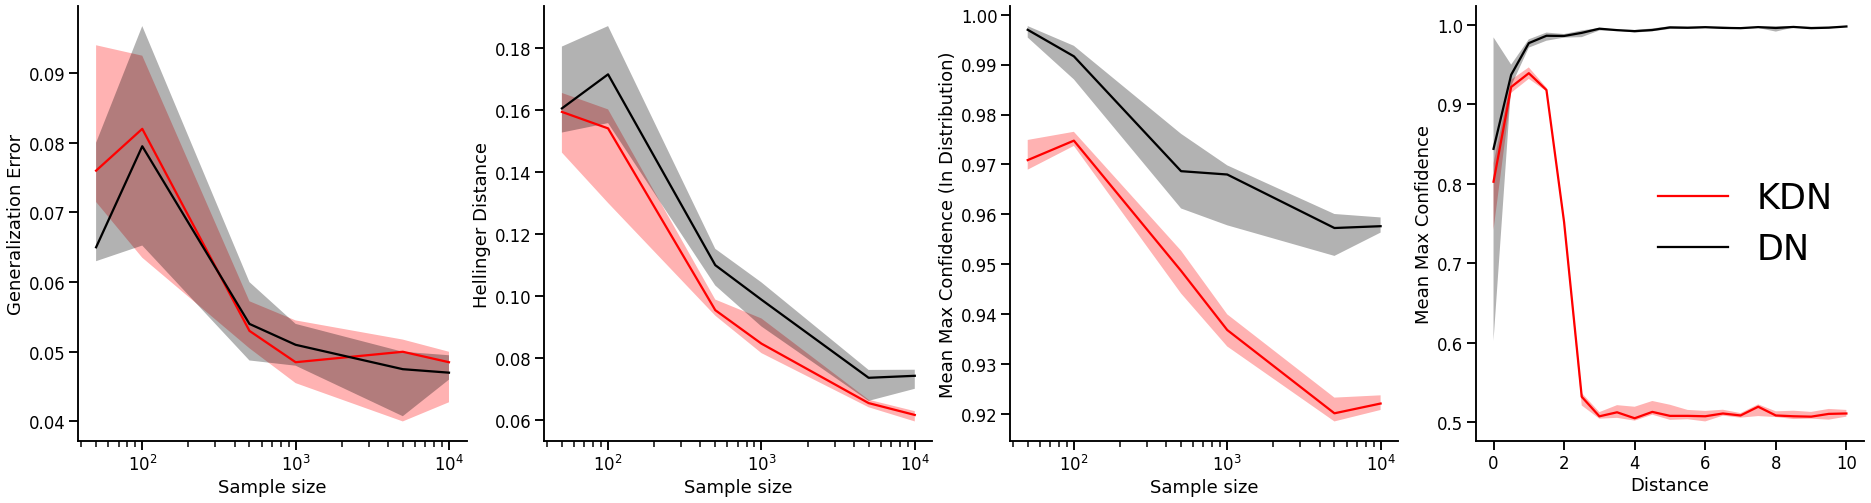

In [12]:
sample_size = [50, 100, 500, 1000, 5000, 10000]

sns.set_context('talk')
fig, ax = plt.subplots(1,4, figsize=(32,8))

ax[0].plot(sample_size, df['error_kdn_med'], c="r", label='KDN')
ax[0].plot(sample_size, df['error_dn_med'], c="k", label='DN')

ax[0].fill_between(sample_size, df['error_kdn_25'], df['error_kdn_75'], facecolor='r', alpha=.3)
ax[0].fill_between(sample_size, df['error_dn_25'], df['error_dn_75'], facecolor='k', alpha=.3)

ax[0].set_xscale('log')
ax[0].set_xlabel('Sample size')
ax[0].set_ylabel('Generalization Error')

right_side = ax[0].spines["right"]
right_side.set_visible(False)
top_side = ax[0].spines["top"]
top_side.set_visible(False)




ax[1].plot(sample_size, df['hellinger_kdn_med'], c="r", label='KDN')
ax[1].plot(sample_size, df['hellinger_dn_med'], c="k", label='DN')

ax[1].fill_between(sample_size, df['hellinger_kdn_25'], df['hellinger_kdn_75'], facecolor='r', alpha=.3)
ax[1].fill_between(sample_size, df['hellinger_dn_25'], df['hellinger_dn_75'], facecolor='k', alpha=.3)

ax[1].set_xscale('log')
ax[1].set_xlabel('Sample size')
ax[1].set_ylabel('Hellinger Distance')

right_side = ax[1].spines["right"]
right_side.set_visible(False)
top_side = ax[1].spines["top"]
top_side.set_visible(False)




ax[2].plot(sample_size, df['mmcIn_kdn_med'], c="r", label='KDN')
ax[2].plot(sample_size, df['mmcIn_dn_med'], c="k", label='DN')

ax[2].fill_between(sample_size, df['mmcIn_kdn_25'], df['mmcIn_kdn_75'], facecolor='r', alpha=.3)
ax[2].fill_between(sample_size, df['mmcIn_dn_25'], df['mmcIn_dn_75'], facecolor='k', alpha=.3)

ax[2].set_xscale('log')
ax[2].set_xlabel('Sample size')
ax[2].set_ylabel('Mean Max Confidence (In Distribution)')

right_side = ax[2].spines["right"]
right_side.set_visible(False)
top_side = ax[2].spines["top"]
top_side.set_visible(False)


r = np.arange(0,10.5,.5)
ax[3].plot(r, df['mmcOut_kdn_med'], c="r", label='KDN')
ax[3].plot(r, df['mmcOut_dn_med'], c="k", label='DN')

ax[3].fill_between(r, df['mmcOut_kdn_25'], df['mmcOut_kdn_75'], facecolor='r', alpha=.3)
ax[3].fill_between(r, df['mmcOut_dn_25'], df['mmcOut_dn_75'], facecolor='k', alpha=.3)

#ax[3].set_xscale('log')
ax[3].set_xlabel('Distance')
ax[3].set_ylabel('Mean Max Confidence')

ax[3].legend(fontsize=35, frameon=False)

right_side = ax[3].spines["right"]
right_side.set_visible(False)
top_side = ax[3].spines["top"]
top_side.set_visible(False)

### OOD detection metrics

In [15]:
def fpr_at_95_tpr(conf_t, conf_f):
    TPR = 95
    PERC = np.percentile(conf_t, 100-TPR)
    FP = np.sum(conf_f >=  PERC)
    FPR = np.sum(conf_f >=  PERC)/len(conf_f)
    return FPR, PERC

In [16]:
sample = 10000
reps = 10
n_test = 1000
true_labels = np.hstack((np.ones(n_test, ), np.zeros(n_test, )))

roc_dn = []
roc_kdn = []

fpr_dn = []
fpr_kdn = []
reps_list = []

for ii in range(reps):
    X, y = generate_gaussian_parity(sample)
    X_test, y_test = generate_gaussian_parity(n_test)
    X_ood = generate_ood_samples(n_test)

    
    nn = getNN(input_size=2, num_classes=2)
    history = nn.fit(X, keras.utils.to_categorical(y), **fit_kwargs)
    model_kdn = kdn(k=.1, network=nn)
    model_kdn.fit(X, y)

    dn_in_conf = np.max(model_kdn.network.predict(X_test), axis=1)
    dn_out_conf = np.max(model_kdn.network.predict(X_ood), axis=1)
    dn_conf = np.hstack((dn_in_conf, dn_out_conf))
    roc_dn.append(
        roc_auc_score(true_labels, dn_conf)
    )
    fpr_dn.append(
        fpr_at_95_tpr(dn_in_conf, dn_out_conf)
    )
    
    

    kdn_in_conf = np.max(model_kdn.predict_proba(X_test), axis=1)
    kdn_out_conf = np.max(model_kdn.predict_proba(X_ood), axis=1)
    kdn_conf = np.hstack((kdn_in_conf, kdn_out_conf))
    roc_kdn.append(
        roc_auc_score(true_labels, kdn_conf)
    )
    fpr_kdn.append(
        fpr_at_95_tpr(kdn_in_conf, kdn_out_conf)
    )

    reps_list.append(ii)

2023-02-20 22:20:46.980717: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 81: early stopping
32/32 [==============================] - 0s 2ms/step


2023-02-20 22:30:14.538187: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 22:30:15.320386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 40: early stopping
32/32 [==============================] - 0s 2ms/step


2023-02-20 22:39:09.687172: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 22:39:10.476774: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 35: early stopping
32/32 [==============================] - 0s 2ms/step


2023-02-20 22:48:04.195296: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 22:48:04.985038: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 84: early stopping
27/32 [========================>.....] - ETA: 0s

2023-02-20 22:57:38.071863: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-02-20 22:57:38.872188: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 28: early stopping
27/32 [========================>.....] - ETA: 0s

2023-02-20 23:06:36.629528: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-02-20 23:06:37.435208: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 30: early stopping
32/32 [==============================] - 0s 2ms/step


2023-02-20 23:15:45.459249: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 23:15:46.259121: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 42: early stopping
32/32 [==============================] - 0s 2ms/step


2023-02-20 23:24:57.547068: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 23:24:58.356632: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 51: early stopping
28/32 [=========================>....] - ETA: 0s

2023-02-20 23:34:01.751608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-02-20 23:34:02.550330: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 66: early stopping
28/32 [=========================>....] - ETA: 0s

2023-02-20 23:43:26.795498: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-02-20 23:43:27.598972: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 83: early stopping
 1/32 [..............................] - ETA: 0s

2023-02-20 23:53:49.430368: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


In [17]:
# obtain the AUROC and FPR@95 scores

# AUROC
print("KDN AUROC = {:.3f} +/- {:.3f}".format(np.mean(roc_kdn), np.std(roc_kdn)))
print("DN AUROC = {:.3f} +/- {:.3f}".format(np.mean(roc_dn), np.std(roc_dn)))

KDN AUROC = 0.969 +/- 0.005
DN AUROC = 0.223 +/- 0.027


In [18]:
# FPR@95
print("KDN FPR@95 = {:.3f} +/- {:.3f}".format(np.mean(fpr_kdn), np.std(fpr_kdn)))
print("DN FPR@95 = {:.3f} +/- {:.3f}".format(np.mean(fpr_dn), np.std(fpr_dn)))

KDN FPR@95 = 0.457 +/- 0.337
DN FPR@95 = 0.910 +/- 0.074


In [12]:
polytope_ids

array([331948751338312552385903309491561272084836295551736852410569684930431463267696262786520903771401030582904683889688626030314281055369842223714137939973175912065430213406815310360824663108201054454774402724772833845308598681176097069711100787445173269371461426089443444142279051819433845905824445113865809843774474707298370314913485914150931971080740798202120461070010989401048547798834493239898697957732281641913088020716698076601753755572818916753049820893624881702172842736564145797162693627578923239663548677773273823194261473872094670691007090815464587704846219771631206974729788691862592872977069823051482640496781783882662224668392796965298663817377929394746376283827987814220291330323985240721996704516232094873253518536168342475618539588340729529798840810110819511680391531953184677936002255392955827737420582261930250613474681210362201051362112368229096344648136223691043023329536935736499876905277668628426011729757942997862112653739661707484424702277945848248039321052252490464512776

In [23]:
b = bin(polytope_ids[0])[2:]

In [26]:
sum(b)

TypeError: unsupported operand type(s) for +: 'int' and 'str'